# ValueInvestor
We are looking to establish a robust intelligent system that can aid investment activities, using past stock performance data. 

Our goal in this project is to use provided historical trading data to predict future stock price valuations on a daily, weekly, and monthly basis. We also provide recommendations on whether to BUY, HOLD or SELL each stock based on the predictions.

### Data Description


We are given trading data from 8 different countries in emerging markets that include the 2020 Q1-Q2-Q3-Q4 and 2021 Q1 stock prices. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. We will only 2020 data and predict with 2021 Q1 data.

Each set of data contain the following columns:
- `Date`
- `Price` (The closing price of the stock on a day)
- `Open` (The opening price of the stock on a day)
- `High` (The highest price of the stock on a day)
- `Low` (The lowest price of the stock on a day)
- `Vol.` (The volume/number of shares that were traded on a day)
- `Change %` (The percentage change from the closing price of the previous day)

### Data Loading
Let's first load the data of the first sheet.

In [52]:
# Import the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx", sheet_name=None)

In [3]:
print(df.keys())

dict_keys(['Russia - Sberbank Rossii PAO (S', 'Turkey - Koc Holding AS (KCHOL)', 'Egypt - Medinet Nasr Housing (M', 'Brazil - Minerva SABrazil (BEEF', 'Argentina - Pampa Energia SA (P', 'Colombia - Cementos Argos SA (C', 'South Africa - Impala Platinum ', 'South Korea - Dongkuk Steel Mil'])


In [4]:
sheet1 = df[list(df.keys())[0]] # Extract the first shee
sheet1 = sheet1.iloc[:-1,:] # Drop the last row
sheet1["Price"].describe(percentiles=[0.25, 0.5, 0.75])

count     311.0
unique    303.0
top       272.0
freq        2.0
Name: Price, dtype: float64

In [5]:
sheet1["Price"].astype(float).describe()

count    311.000000
mean     234.524019
std       32.079847
min      174.270000
25%      207.700000
50%      229.140000
75%      264.380000
max      293.300000
Name: Price, dtype: float64

In [6]:
sheet1["Change %"].describe()

count    311.000000
mean       0.000668
std        0.021931
min       -0.095700
25%       -0.010100
50%        0.000400
75%        0.012950
max        0.129000
Name: Change %, dtype: float64

### Data Exploration

#### Check for missing values

In [7]:
sheet1.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

#### Check for outliers

In [41]:
fig = px.box(sheet1, x="Price")
fig.show()

In [42]:
fig = px.box(sheet1, x="Open")
fig.show()

In [43]:
fig = px.box(sheet1, x="High")
fig.show()

In [44]:
fig = px.box(sheet1, x="Low")
fig.show()

In [12]:
sheet1['Vol.'].str[:-1].astype(float)

0      47.00
1      38.81
2      43.68
3      56.07
4      35.22
       ...  
306    18.85
307    38.33
308    40.82
309    22.35
310    35.85
Name: Vol., Length: 311, dtype: float64

In [48]:
sheet1['Vol.'] = sheet1['Vol.'].str[:-1].astype(float)
fig = px.box(sheet1, x='Vol.')
fig.show()

In [49]:
sheet1['Vol.'].describe()

count    311.000000
mean      73.056977
std       38.058095
min        8.760000
25%       47.670000
50%       66.260000
75%       85.120000
max      263.040000
Name: Vol., dtype: float64

In [40]:
fig = px.box(sheet1, x="Change %")
fig.show()

In [15]:
sheet1['Change %'].describe()

count    311.000000
mean       0.000668
std        0.021931
min       -0.095700
25%       -0.010100
50%        0.000400
75%        0.012950
max        0.129000
Name: Change %, dtype: float64

Plot the price over time.

In [51]:
fig = px.line(sheet1, x='Datetime', y="Price")
fig.show()

### ARIMA (Autoregressive integrated moving average)

#### Check assumptions of the ARIMA model
The following assumptions need to be satisified:
- Data should be stationary
- Data should be univariate

To check that the data is stationary, we can use the ADF (Augmented Dickey-Fuller) Test.

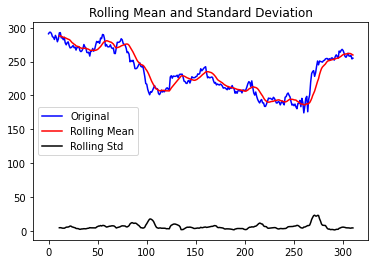

Results of dickey fuller test
Test Statistics                 -1.847182
p-value                          0.357301
No. of lags used                 8.000000
Number of observations used    302.000000
critical value (1%)             -3.452190
critical value (5%)             -2.871158
critical value (10%)            -2.571895
dtype: float64


In [17]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(sheet1.Price)

As the p-value > 0.05, we can't rule out the null hypothesis that a unit root exists in this sample.

In [18]:
# TODO: Split into trend component (increasing/decreasing)
# Then add seasonality component (e.g. due to fluctuations in particular times)
# Then error component

<Figure size 432x288 with 0 Axes>

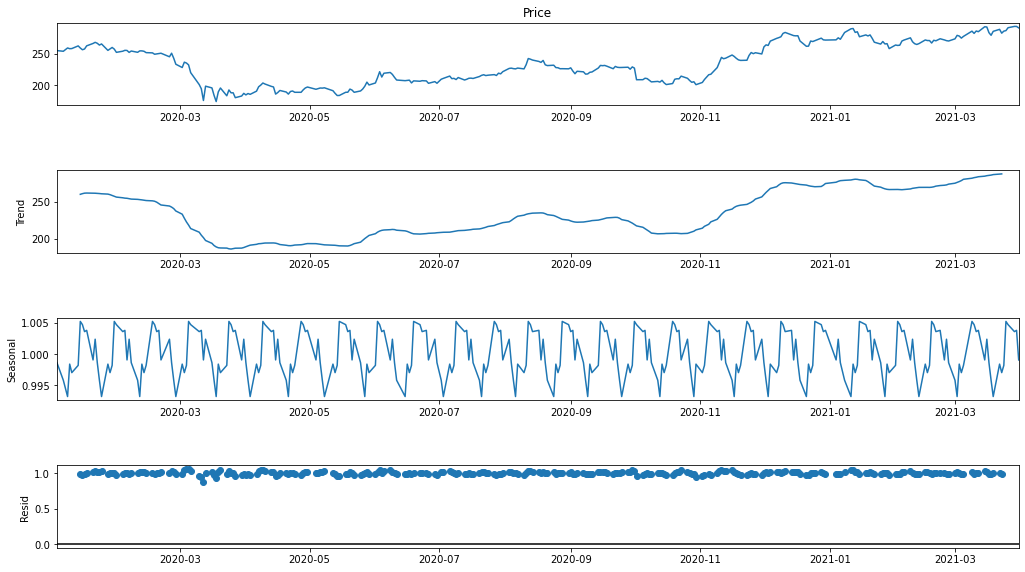

In [91]:
# Separate the trend and the seasonality from a time series
result = seasonal_decompose(sheet1.set_index(pd.DatetimeIndex(sheet1["Datetime"])).sort_index().Price, period=12, model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Now lets split the data into training and testing data.

In [19]:
sheet1["Datetime"] < datetime.strptime("2020-01-10", "%Y-%m-%d")

0      False
1      False
2      False
3      False
4      False
       ...  
306    False
307     True
308     True
309     True
310     True
Name: Datetime, Length: 311, dtype: bool

In [20]:
train_data = sheet1[sheet1["Datetime"] < datetime.strptime("2020-10-01", "%Y-%m-%d")]
test_data = sheet1[(sheet1["Datetime"] >= datetime.strptime("2020-10-01", "%Y-%m-%d")) & (sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d"))]

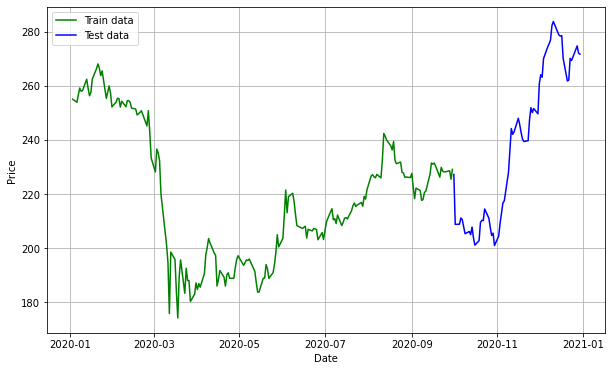

In [21]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train_data["Datetime"], train_data["Price"], 'green', label='Train data')
plt.plot(test_data["Datetime"], test_data["Price"], 'blue', label='Test data')
plt.legend()

In [22]:
# TODO: Choose p,d, and q values
# Try to understand these values
# ARIMAX

In [101]:
np.log(train_data["Price"].astype(float))

125    5.434333
126    5.418231
127    5.432105
128    5.430398
129    5.430091
         ...   
306    5.553696
307    5.552921
308    5.557407
309    5.536940
310    5.541264
Name: Price, Length: 186, dtype: float64

In [105]:
model_autoARIMA.order

(0, 1, 0)

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  186
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -556.663
Date:                Wed, 09 Nov 2022   AIC                           1115.325
Time:                        15:41:22   BIC                           1118.545
Sample:                             0   HQIC                          1116.630
                                - 186                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        24.0491      1.436     16.748      0.000      21.235      26.863
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               127.38
Prob(Q):                              0.69   Pr

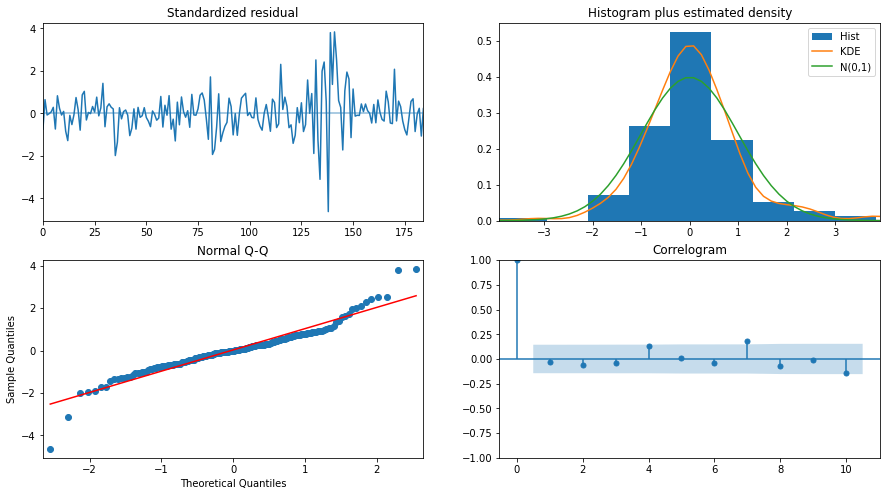

In [103]:
# Use Auto ARIMA to find the best p, d, and q values
model_autoARIMA = auto_arima(train_data["Price"], m=12)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

We get the result, `Best model:  ARIMA(0,1,0)(0,0,0)[0]`, therefore the best parameters are p=0, d=1, q=0.

In [24]:
# Build Model
model = ARIMA(train_data["Price"].astype(float), order=(0,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  186
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -556.663
Date:                Tue, 08 Nov 2022   AIC                           1115.325
Time:                        14:49:14   BIC                           1118.545
Sample:                             0   HQIC                          1116.630
                                - 186                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        24.0491      1.436     16.748      0.000      21.235      26.863
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               127.38
Prob(Q):                              0.69   Pr

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Forecast on test dataset

In [25]:
test_data

,Date,Price,Open,High,Low,Vol.,Change %,Datetime
61,2020-12-30 00:00:00,271.65,272.49,274.24,270.12,31.53M,-0.0013,2020-12-30
62,2020-12-29 00:00:00,272.0,275.91,276.43,271.26,39.02M,-0.0098,2020-12-29
63,2020-12-28 00:00:00,274.7,270.9,275.19,269.73,39.04M,0.0150,2020-12-28
64,2020-12-25 00:00:00,270.64,269.97,271.0,268.28,11.99M,0.0049,2020-12-25
65,2020-12-24 00:00:00,269.32,271.98,272.82,267.13,42.61M,-0.0029,2020-12-24
...,...,...,...,...,...,...,...,...
120,2020-10-07 00:00:00,210.6,211.3,212.66,209.03,62.05M,-0.0027,2020-10-07
121,2020-10-06 00:00:00,211.18,209.0,212.99,208.35,87.53M,0.0110,2020-10-06
122,2020-10-05 00:00:00,208.89,209.65,210.69,207.72,45.60M,0.0004,2020-10-05
123,2020-10-02 00:00:00,208.8,210.4,211.39,206.5,114.32M,-0.0811,2020-10-02


In [26]:
predicted = fitted.get_prediction(start=124)

In [27]:
predicted_ci = fitted.conf_int()

In [28]:
predicted.predicted_mean

249    185.64
250    186.95
251    184.78
252    187.21
253    183.00
        ...  
306    262.40
307    258.19
308    257.99
309    259.15
310    253.90
Name: predicted_mean, Length: 62, dtype: float64

In [29]:
sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")]

,Date,Price,Open,High,Low,Vol.,Change %,Datetime
61,2020-12-30 00:00:00,271.65,272.49,274.24,270.12,31.53M,-0.0013,2020-12-30
62,2020-12-29 00:00:00,272.0,275.91,276.43,271.26,39.02M,-0.0098,2020-12-29
63,2020-12-28 00:00:00,274.7,270.9,275.19,269.73,39.04M,0.0150,2020-12-28
64,2020-12-25 00:00:00,270.64,269.97,271.0,268.28,11.99M,0.0049,2020-12-25
65,2020-12-24 00:00:00,269.32,271.98,272.82,267.13,42.61M,-0.0029,2020-12-24
...,...,...,...,...,...,...,...,...
306,2020-01-10 00:00:00,258.19,257.86,259.25,256.88,18.85M,0.0008,2020-01-10
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045,2020-01-09
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207,2020-01-08
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043,2020-01-06


In [30]:
sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")]

,Date,Price,Open,High,Low,Vol.,Change %,Datetime
61,2020-12-30 00:00:00,271.65,272.49,274.24,270.12,31.53M,-0.0013,2020-12-30
62,2020-12-29 00:00:00,272.0,275.91,276.43,271.26,39.02M,-0.0098,2020-12-29
63,2020-12-28 00:00:00,274.7,270.9,275.19,269.73,39.04M,0.0150,2020-12-28
64,2020-12-25 00:00:00,270.64,269.97,271.0,268.28,11.99M,0.0049,2020-12-25
65,2020-12-24 00:00:00,269.32,271.98,272.82,267.13,42.61M,-0.0029,2020-12-24
...,...,...,...,...,...,...,...,...
306,2020-01-10 00:00:00,258.19,257.86,259.25,256.88,18.85M,0.0008,2020-01-10
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045,2020-01-09
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207,2020-01-08
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043,2020-01-06


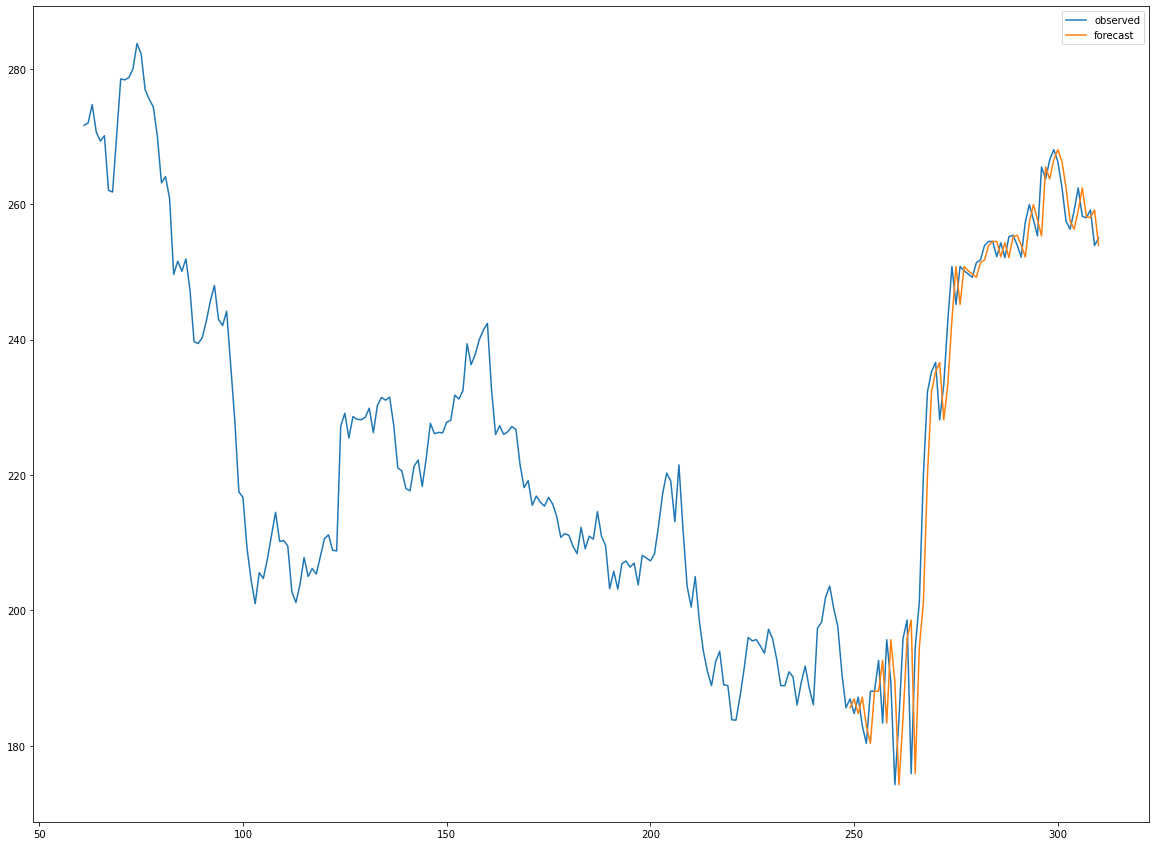

In [31]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

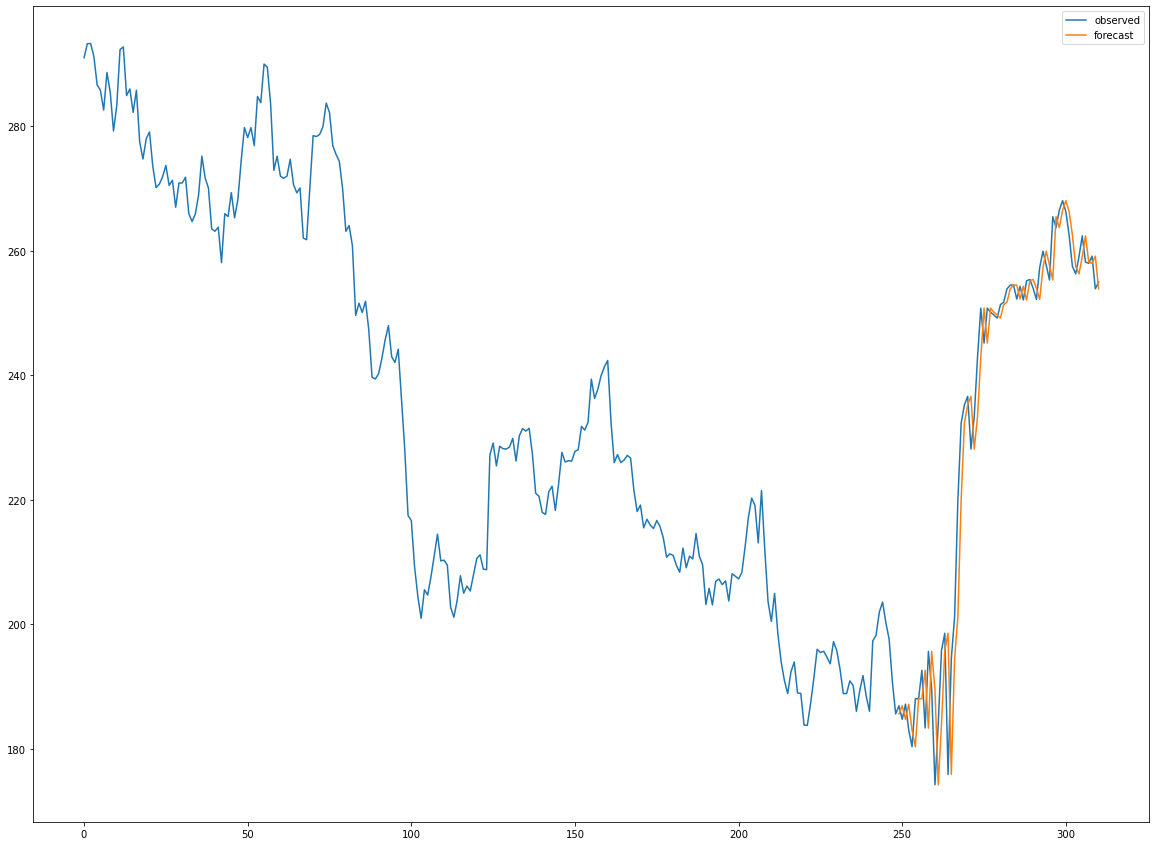

In [32]:
ax = sheet1.Price.plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

In [34]:
!pip install "jupyterlab>=3" "ipywidgets>=7.6"

In [35]:

fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
fig.show()

In [33]:
# TODO: Try the Plotly package for plotting graphs

### Forecast Future Unknown Data

### Summary